In [1]:
# use geo_env_2022
import os
import numpy as np
import pandas as pd # original 1.2.3
import geopandas as gpd
from shapely.geometry import Point
import pickle
import urllib.request

import matplotlib.pyplot as plt


In [2]:
def get_prio_shape():

    location = '/home/simon/Documents/Bodies/data/PRIO'
    path_prio = location + '/priogrid_shapefiles.zip'

    if os.path.isfile(path_prio) == True:
        
        print('File already downloaded')
        prio_grid = gpd.read_file('zip://' + path_prio)

    else:
        print('Beginning file download PRIO...')
        url_prio = 'http://file.prio.no/ReplicationData/PRIO-GRID/priogrid_shapefiles.zip'

        urllib.request.urlretrieve(url_prio, path_prio)
        prio_grid = gpd.read_file('zip://' + path_prio)

    return prio_grid

In [3]:
def get_gwno():

    location = '/home/simon/Documents/Bodies/data/PRIO'
    #path_gwno = location + '/PRIO-GRID Yearly Variables for 2003-2009 - 2022-06-16.csv' #https://grid.prio.org/#/download # need to figrue out the API
    path_gwno = location + '/PRIO-GRID Yearly Variables for 1989-2014 - 2022-06-16.csv' #https://grid.prio.org/#/download # need to figrue out the API

    # why not just go 1989 - 2019 like ucdp...

    gwno = pd.read_csv(path_gwno)

    return gwno



In [4]:
def get_ucdp():
    location = '/home/simon/Documents/Bodies/data/UCDP' 
    path_ucdp = location + "/ged201-csv.zip"
    
    if os.path.isfile(path_ucdp) == True:
        print('file already downloaded')
        ucdp = pd.read_csv(path_ucdp)


    else: 
        print('Beginning file download UCDP...')

        url_ucdp = 'https://ucdp.uu.se/downloads/ged/ged201-csv.zip'
    
        urllib.request.urlretrieve(url_ucdp, path_ucdp)
        ucdp = pd.read_csv(path_ucdp)

    return ucdp

In [5]:
def add_months(ucdp, world_grid):

    diff = ucdp['year'].max() - world_grid['year'].max()

    subset_list = []

    for i in np.arange(1, diff+1, 1):

        subset = world_grid[world_grid['year'] == world_grid['year'].max()].copy()
        subset['year'] = world_grid['year'].max() + i

        subset_list.append(subset)

    new_years = pd.concat(subset_list)
    world_grid_all_years = pd.concat([world_grid, new_years])

    month = [str(i).zfill(2) for i in np.arange(1,13,1)]
    world_grid_all_years.loc[:,'month'] = world_grid_all_years.apply(lambda _: month, axis=1)
    world_grid_all_months = world_grid_all_years.sort_values('year').explode('month').copy()
    world_grid_all_months['year_months_start'] =  world_grid_all_months['year'].astype(str) + '-' +  world_grid_all_months['month'].astype(str)

    year_months = sorted(world_grid_all_months['year_months_start'].unique())
    ts = len(year_months)
    month_ids = np.arange(109, ts + 109, 1)
    month_id_dict = dict(zip(year_months,month_ids))
    month_df = pd.DataFrame({'year_months_start' : year_months, 'month_id': month_ids})
    world_grid_all_months_id = world_grid_all_months.merge(month_df, how = 'left', on = 'year_months_start')

    return world_grid_all_months_id

In [6]:
def prio_ucdp_merge(ucdp, world_grid_all_months):
    ucdp_tmp1 = ucdp.copy()

    ucdp_tmp1['year_months_start'] = ucdp_tmp1['date_start'].str.slice(start = 0, stop = 7) # Date YYYY-MM-DD
    ucdp_tmp1['year_months_end'] = ucdp_tmp1['date_start'].str.slice(start = 0, stop = 7) # Date YYYY-MM-DD


    mask1 = (ucdp_tmp1['year'] != ucdp_tmp1['year_months_start'].str.slice(start = 0, stop = 4).astype(int))
    mask2 = (ucdp_tmp1['year'] != ucdp_tmp1['year_months_end'].str.slice(start = 0, stop = 4).astype(int))

    # correction. Note that end and start year for the four entries that is corrected is the same.
    ucdp_tmp1.loc[mask1 | mask2, 'year'] = ucdp_tmp1.loc[mask1 | mask2,'year_months_start'].str.slice(start = 0, stop = 4).astype(int)

    ucdp_monthly_unit = ucdp_tmp1.groupby(['year_months_start','year', 'priogrid_gid']).sum()[['best','low','high']].reset_index()
    ucdp_monthly_unit.rename(columns={'priogrid_gid':'gid'}, inplace=True)

    ucdp_monthly_unit['log_best'] = np.log(ucdp_monthly_unit['best'] +1)
    ucdp_monthly_unit['log_low'] = np.log(ucdp_monthly_unit['low'] +1)
    ucdp_monthly_unit['log_high'] = np.log(ucdp_monthly_unit['high'] +1)

    prio_ucdp_df = world_grid_all_months.merge(ucdp_monthly_unit, how = 'left', on = ['gid', 'year_months_start', 'year'])
    prio_ucdp_df.fillna(0, inplace=True)

    return prio_ucdp_df

In [7]:
prio_grid = get_prio_shape()
gwno = get_gwno()
ucdp = get_ucdp()

world_grid = prio_grid.merge(gwno, how = 'right', on = 'gid') # if you just merge this on outer I think you get the full grid needed for R-UNET
world_grid_all_months = add_months(ucdp, world_grid)
prio_ucdp = prio_ucdp_merge(ucdp, world_grid_all_months)


File already downloaded
file already downloaded


/tmp/ipykernel_47087/3991126561.py:7: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  ucdp = pd.read_csv(path_ucdp)


In [8]:
prio_ucdp

,gid,xcoord,ycoord,col,row,geometry,year,gwno,month,year_months_start,month_id,best,low,high,log_best,log_low,log_high
0,239205,-97.75,76.25,165,333,"POLYGON ((-98.00000 76.00000, -98.00000 76.500...",1989,20.0,01,1989-01,109,0.0,0.0,0.0,0.0,0.0,0.0
1,239205,-97.75,76.25,165,333,"POLYGON ((-98.00000 76.00000, -98.00000 76.500...",1989,20.0,02,1989-02,110,0.0,0.0,0.0,0.0,0.0,0.0
2,239205,-97.75,76.25,165,333,"POLYGON ((-98.00000 76.00000, -98.00000 76.500...",1989,20.0,03,1989-03,111,0.0,0.0,0.0,0.0,0.0,0.0
3,239205,-97.75,76.25,165,333,"POLYGON ((-98.00000 76.00000, -98.00000 76.500...",1989,20.0,04,1989-04,112,0.0,0.0,0.0,0.0,0.0,0.0
4,239205,-97.75,76.25,165,333,"POLYGON ((-98.00000 76.00000, -98.00000 76.500...",1989,20.0,05,1989-05,113,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24112291,249344,-68.25,83.25,224,347,"POLYGON ((-68.50000 83.00000, -68.50000 83.500...",2019,20.0,08,2019-08,476,0.0,0.0,0.0,0.0,0.0,0.0
24112292,249344,-68.25,83.25,224,347,"POLYGON ((-68.50000 83.00000, -68.50000 83.500...",2019,20.0,09,2019-09,477,0.0,0.0,0.0,0.0,0.0,0.0
24112293,249344,-68.25,83.25,224,347,"POLYGON ((-68.50000 83.00000, -68.50000 83.500...",2019,20.0,10,2019-10,478,0.0,0.0,0.0,0.0,0.0,0.0
24112294,249344,-68.25,83.25,224,347,"POLYGON ((-68.50000 83.00000, -68.50000 83.500...",2019,20.0,11,2019-11,479,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
print(prio_ucdp.groupby('gid').count()['month_id'].unique()) # checks out

[372]


In [10]:
for y in sorted(prio_ucdp['year'].unique()):
    array = list(prio_ucdp[prio_ucdp['year'] == y]['month_id'].unique())
    print(f'{y}: {array}')

1989: [109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]
1990: [121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
1991: [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144]
1992: [145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156]
1993: [157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168]
1994: [169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180]
1995: [181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192]
1996: [193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204]
1997: [205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216]
1998: [217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228]
1999: [229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240]
2000: [241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252]
2001: [253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264]
2002: [265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276]
2003: [277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 

In [11]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.to_crs(prio_ucdp.crs)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


409: 2014-01


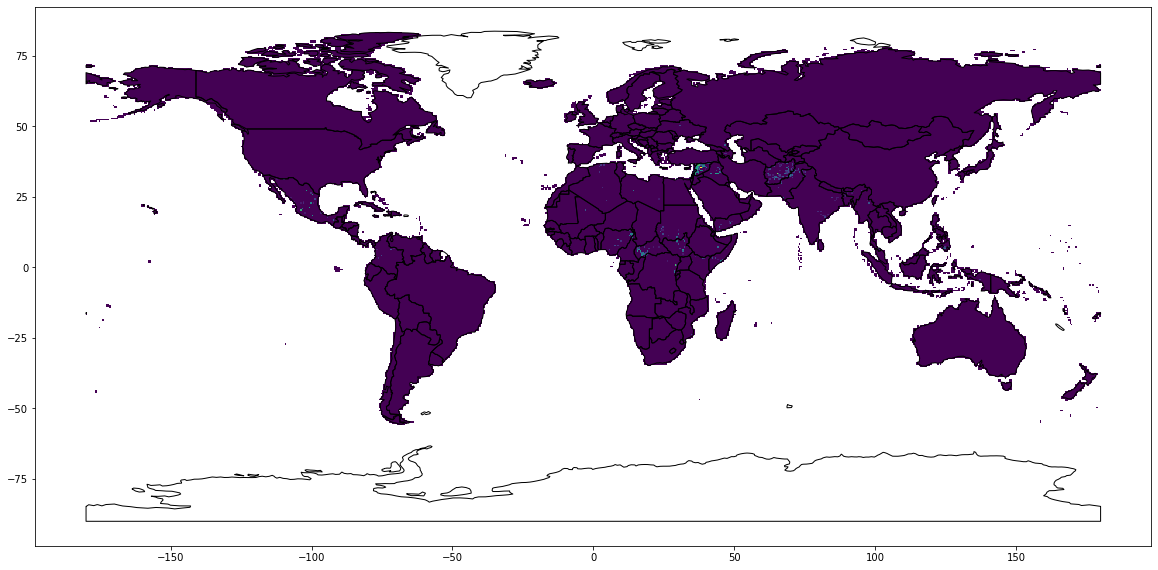

410: 2014-02


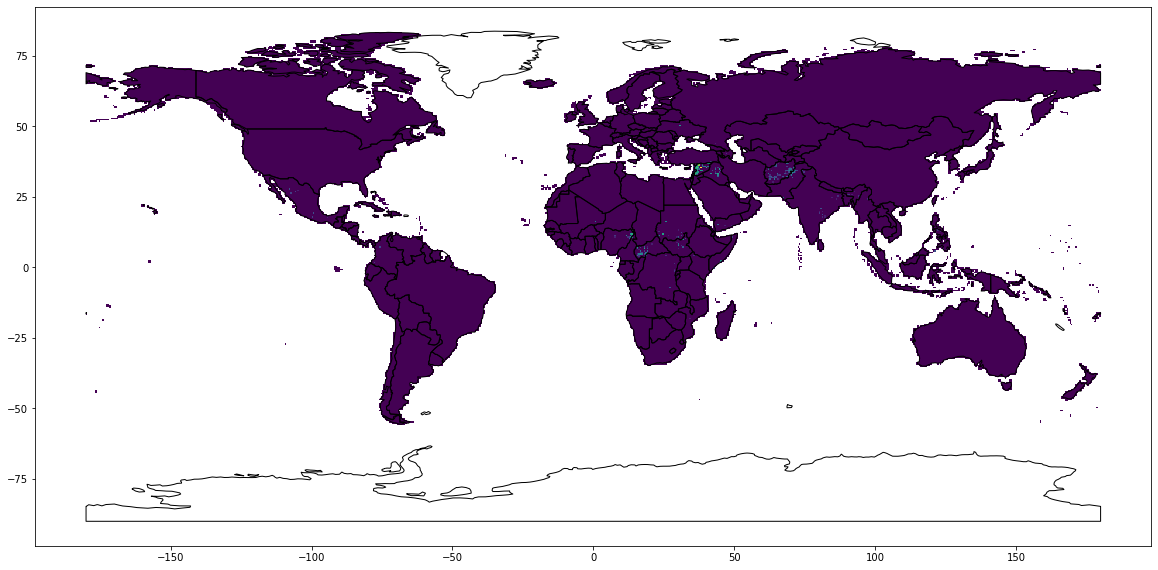

411: 2014-03


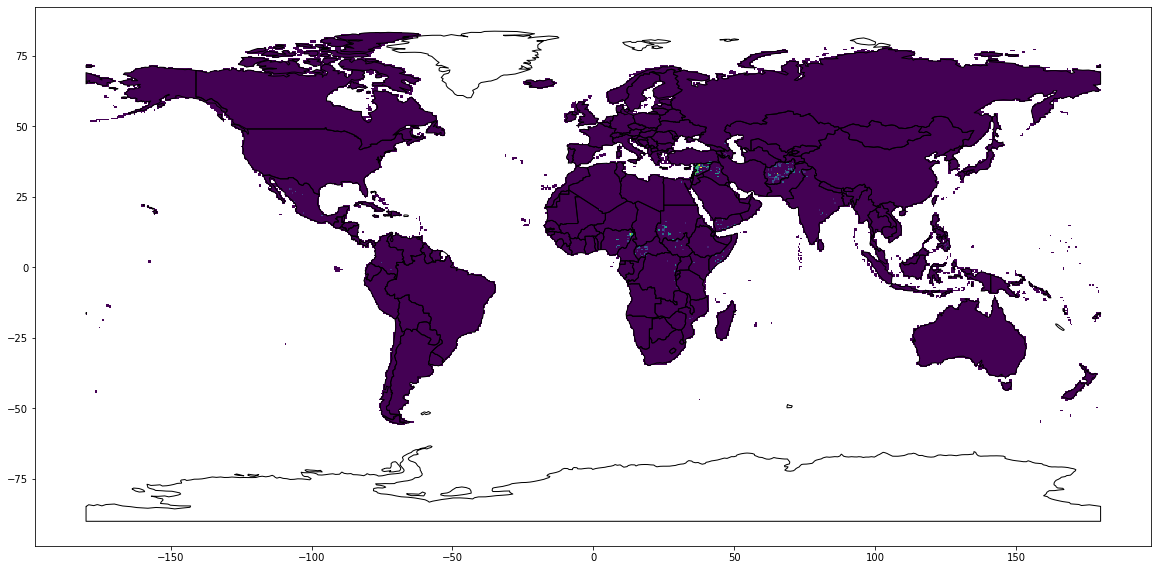

412: 2014-04


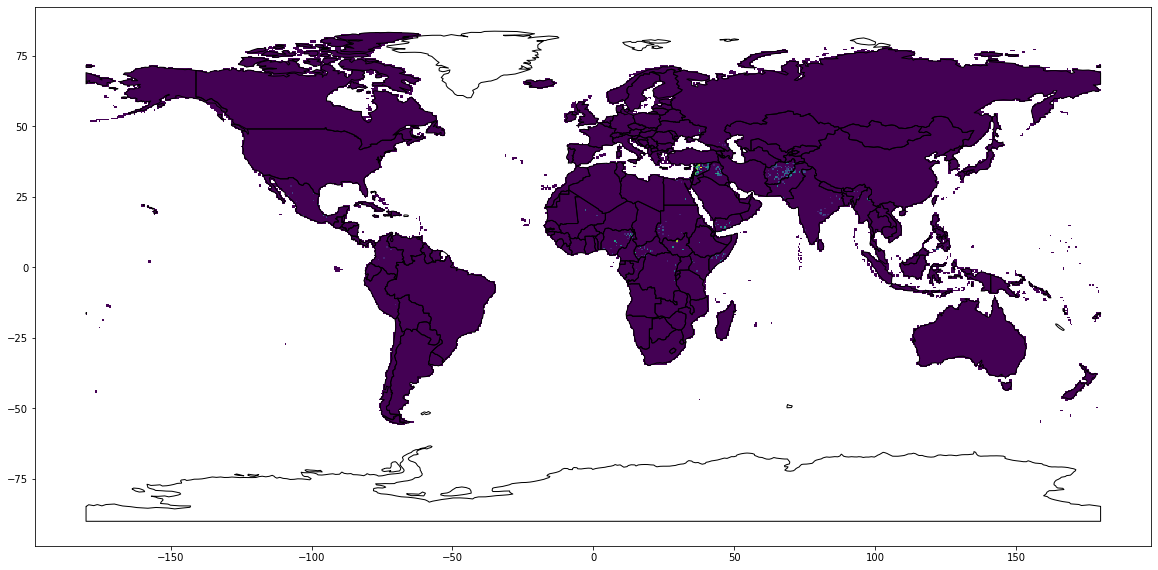

413: 2014-05


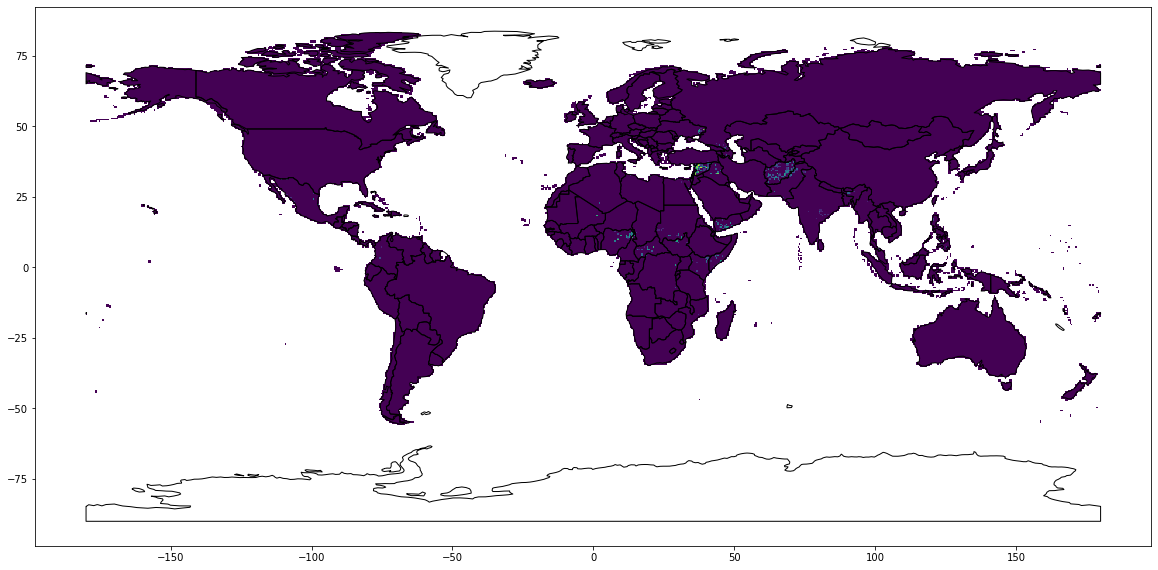

In [12]:
for i in sorted(prio_ucdp['month_id'].unique())[300:305]:

    print(f"{i}: {prio_ucdp[prio_ucdp['month_id'] == i]['year_months_start'].unique().item()}")
    fig, ax = plt.subplots(figsize = (20,20))
    prio_ucdp[prio_ucdp['month_id'] == i].plot(ax=ax, column = 'log_best')
    world.plot(facecolor='none', edgecolor='black', ax=ax)
    plt.show()

In [14]:
data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'

with open(f'{data_dir}g_df_ucdp_prio.pkl', 'wb') as file:
    pickle.dump(prio_ucdp, file)

prio_ucdp_pd = pd.DataFrame(prio_ucdp.drop(columns= 'geometry').copy())

with open(f'{data_dir}df_ucdp_prio.pkl', 'wb') as file:
    pickle.dump(prio_ucdp_pd, file)

# could also save it as a non-geopandas...